# Cycling Data Exploration

The vast majority of cyclists, whether you're a casual weekend warrior or a hardened clubman, now have GPS devices on their bikes. These devices measure speed, elevation, distance and temperature (to name a few). They also connect with other devices such as heart rate monitors, cadence sensors and power meters. This provides the cyclist with a plethora of data while riding. More importantly though, all this data is saved by the GPS device which you can upload to your favourite fitness tracking site during your post-ride laze about. 

The analysis that these fitness sites provide is good, but what if you want to do it yourself? This post shows how to load and explore your own data from a file. I personally use a Garmin Edge 200 which saves the data in a .fit file. In order to extract the data, the fitparse 1.0.1 package ([GitHub link](https://github.com/dtcooper/python-fitparse)) with python 2.7. This post will load data from a single ride and produce some simple visualisations of the data. 

## Loading the data

We're going to load the data from a single ride I did on 1st November 2017 ([ride on Strava](https://www.strava.com/activities/1256046514)). For this ride I simply went out for 50 minutes steady riding. Let us load the file into python using the fitparse package and then display a single data point. Each data point corresponds to the information recorded at a particular point in time; the fitparse package calls each data point a 'record'. The code below loads the file and then displays the data for the very first entry for this ride. 

In [216]:
from fitparse import FitFile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Extract ride data from file
myFitFile = FitFile('data/2017-11-01-09-23-16.fit')

# Show all variables, values, and units for the first record
for record in myFitFile.get_messages('record') :
    
    for data in record : print data
    break

altitude: 9.6 [m]
cadence: 92 [rpm]
distance: 115.56 [m]
enhanced_altitude: 9.6 [m]
enhanced_speed: 5.493 [m/s]
heart_rate: 121 [bpm]
position_lat: 617376008 [semicircles]
position_long: -14758821 [semicircles]
power: 125 [watts]
speed: 5.493 [m/s]
temperature: 15 [C]
timestamp: 2017-11-01 09:23:39


Brilliant, all the variables we expect to see are here (though I'm not sure what enhanced_altitude and enhanced_speed are). Let's now decide what variables we care about and extract their variables from all data points. For now we will consider cadence, distance, heartrate and power.

In [217]:
# make a list of variable names, and a list to store the data
myVariables = [ 'cadence', 'distance', 'heart_rate', 'power' ]
myData = []

# Loop through all data points/records
for record in myFitFile.get_messages('record') :

    # Extract only the variables specified above, using list comprehension
    myData.append( [ data.value for data in record if data.name in myVariables ] )

myData = np.asarray( myData ) # make into a 2D numpy array

print "Total number of data points:", myData.shape[0]
print myVariables[0], myVariables[1], myVariables[2], myVariables[3]
print myData[:10,:]

Total number of data points: 2977
cadence distance heart_rate power
[[  92.    115.56  121.    125.  ]
 [  89.    120.62  121.    140.  ]
 [  85.    126.33  122.    152.  ]
 [  82.    133.04  123.    157.  ]
 [  97.    138.63  124.    138.  ]
 [ 111.    144.69  125.    150.  ]
 [  94.    150.77  126.    155.  ]
 [ 114.    156.96  127.    146.  ]
 [  99.    162.66  128.    224.  ]
 [  93.    169.51  129.    163.  ]]


The 'distance' variable gives us the cumulative distance up until that data point. We should do a sanity check and make sure the final distance matches the total distance provided by Strava (roughly 20km).

In [218]:
print "Total distance:", myData[-1,1]/1000, "km"

Total distance: 20.6136 km


## Plotting the data

We now have our data in a sensible format. Let's first plot the time series of each variable.

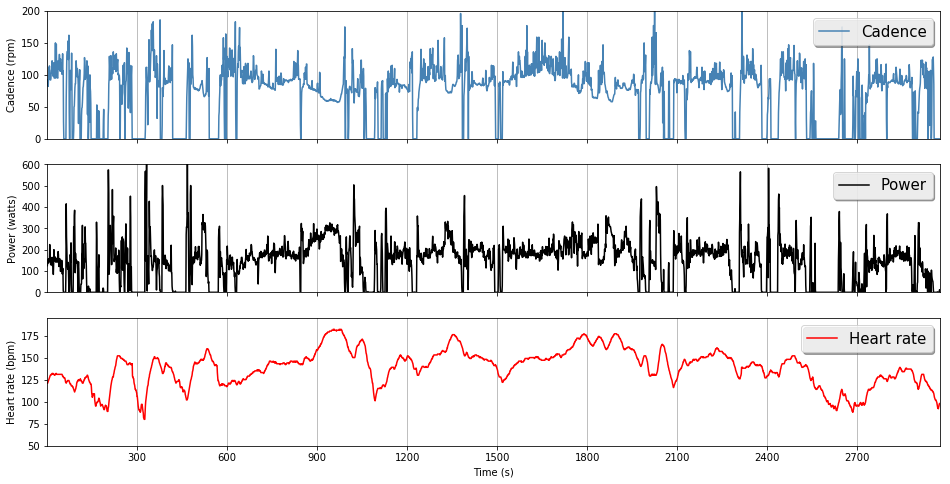

In [219]:
fig, (ax0,ax1,ax2) = plt.subplots( 3, 1, sharex=True )
fig.set_size_inches( (16,8) )

ax0.plot( myData[:,0], color='steelblue', label='Cadence' )
ax0.set_xlim( ( 0, myData.shape[0] ) )
ax0.set_ylim( (0,200) )
ax0.xaxis.set_ticks( np.linspace(300,2700,9) )
ax0.xaxis.grid(True)
ax0.set_ylabel('Cadence (rpm)')
ax0.legend( shadow=True, fontsize=15 )

ax1.plot( myData[:,3], color='black', label='Power' )
ax1.set_xlim( ( 0, myData.shape[0] ) )
ax1.set_ylim( ( 0, 600 ) )
ax1.xaxis.grid( True )
ax1.set_ylabel('Power (watts)')
ax1.legend( shadow=True, fontsize=15 )

ax2.plot( myData[:,2], color='red', label='Heart rate' )
ax2.set_xlim( ( 0, myData.shape[0] ) )
ax2.set_ylim( ( 50, 195 ) )
ax2.xaxis.grid( True )
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Heart rate (bpm)')
ax2.legend( shadow=True, fontsize=15 )

We can see that the cadence and power variables are much more variable/noisy compared to heart rate. Heart rate is a relatively smooth time series where as cadence and power react instantly to changes in effort, e.g. when you stop pedalling on a downhill section. Let's now examine the probability distributions of each variable. This can tell us about particular regimes of behaviour of a variable. 

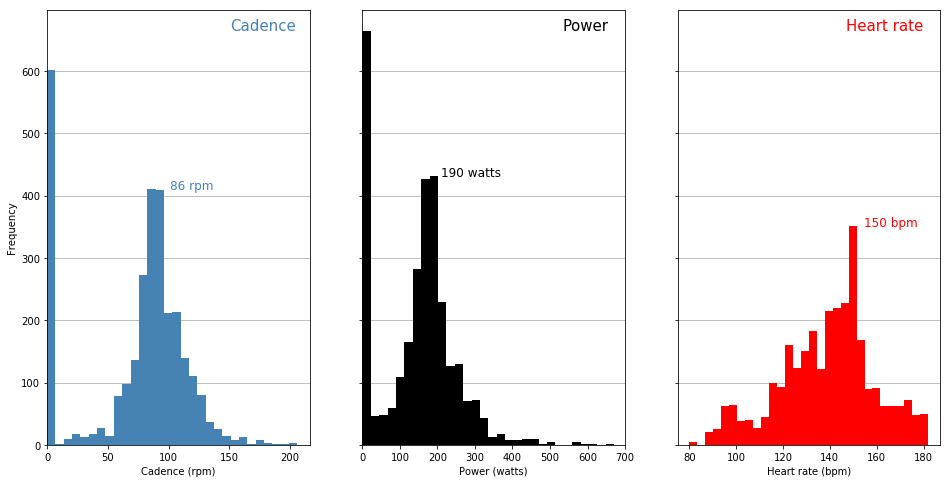

In [220]:
fig, (ax0,ax1,ax2) = plt.subplots( 1, 3, sharey=True )
fig.set_size_inches( (16,8) )

[ freq0, bins0, p0] = ax0.hist( myData[:,0], 30, color='steelblue' )
ax0.set_xlabel('Cadence (rpm)')
ax0.set_xlim( (0.210) )
ax0.set_ylabel('Frequency')
ax0.text( 205, 665, 'Cadence', color='steelblue', ha='right', size=15 )
ax0.set_axisbelow(True)
ax0.yaxis.grid(True)

[ freq1, bins1, p1 ] = ax1.hist( myData[:,3], 30, color='black' )
ax1.set_xlabel('Power (watts)')
ax1.set_xlim( (0,700) )
ax1.text( 655, 665, 'Power', color='black', ha='right', size=15 )
ax1.set_axisbelow(True)
ax1.yaxis.grid(True)

[ freq2, bins2, p2 ] = ax2.hist( myData[:,2], 30, color='red' )
ax2.set_xlabel('Heart rate (bpm)')
ax2.text( 180, 665, 'Heart rate', color='red', ha='right', size=15 )
ax2.set_axisbelow(True)
ax2.yaxis.grid(True)

##### Annotate the most frequent value (ignoring zero for cadence and power) #####

# change first frequency of candence and power to zero
freq0[0], freq1[0] = 0, 0   

# calculate bin centers
c0, c1, c2 = 0.5*( bins0[1:] + bins0[:-1] ), 0.5*( bins1[1:] + bins1[:-1] ), 0.5*( bins2[1:] + bins2[:-1] ),

# get most frequent value
max0, max1, max2 = c0[ freq0 == np.max(freq0) ], c1[ freq1 == np.max(freq1) ], c2[ freq2 == np.max(freq2) ] 

# make annotations
ax0.text( max0+15, np.max(freq0), str( int( np.round( max0[0] ) ) )+' rpm', color='steelblue', fontsize=12 )
ax1.text( max1+20, np.max(freq1), str( int( np.round( max1[0] ) ) )+' watts', color='black', fontsize=12 )
ax2.text( max2+5, np.max(freq2), str( int( np.round( max2[0] ) ) )+' bpm', color='red', fontsize=12 )


Both cadance and power have huge spikes at zero due to downhill sections. They also have relatively sharp peaks around their modes (86 rpm and 190 watts). Heart rate on the other hand is a much broader distribution about its mode of 150 bpm. This distributions show that the ride was particularly steady, in that the effort was fairly consistent. If we plotted the same distributions for a criterium, mountain bike race, or an interval session, we would see additional peaks at larger values. These peaks at larger values would reflect the extremely intense efforts that are associated with an increase in power and heart rate - and possibly cadence depending on the situation. 

## The relationship between power and heart rate

Most cyclists know that heart rate takes a bit of time to react to an increase in effort. If you do an all-out sprint for 10 seconds, your heart rate won't respond until after the effort has ended. Generally though, an increase in effort leads to an increase in heart rate. We therefore expect some linear relationship between power output and heart rate, even if there is a time-lag between the changes. This linear relationship doesn't hold all the time, due to the fact that when a cyclist goes above their anaerobic threshold, power output decouples from heart rate. We'll ignore this for now though and try to quantify the linear relationship between heart rate and power.

We're going to plot the cross-correlation. This shows the linear correlation between two variables at different time lags. A correlation value of one (or minus one) means that two variables are perfectly linearly related, while a value of zero means there is no linear relation. We expect there to be some positive correlation between the power and heart rate, and that the heart rate will lag the power.

Before computing the cross-correlations, standardise the data by removing the meana and dividing by the standard deviation.

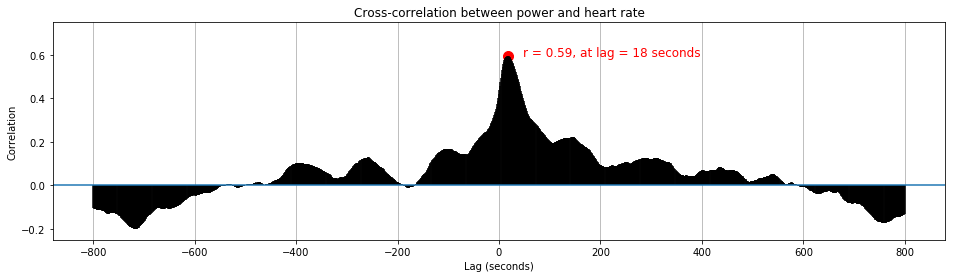

In [221]:
y1 = ( myData[:,2] - np.mean( myData[:,3] ) ) / np.std( myData[:,2] )  # standardise heart rate
y2 = ( myData[:,3] - np.mean( myData[:,3] ) ) / np.std( myData[:,3] )  # standardise power

[ lag, r, line, b ] = plt.xcorr( y1, y2, maxlags=800 )

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches( (16,4))
ax.set_xlabel('Lag (seconds)')
ax.set_ylabel('Correlation')
ax.set_title('Cross-correlation between power and heart rate')
ax.xaxis.grid(True)
ax.set_ylim( (-0.25,0.75) )

# annotate the maximum correlation
rMax = np.max(r)
lagMax = lag[ r == rMax ]

plt.scatter( lagMax, rMax, s=100, color='red' )
plt.text( lagMax+30, rMax, 'r = '+str(np.round(rMax,2))+', at lag = '+str(lagMax[0])+' seconds',
         fontsize=12, color='red' )


We get a nice strong signal; heart rate and power are positively correlated! We also know how long it takes for a change in power to elicit a change in heart rate: 18 seconds. It would be interesting to see if this delay varies between cyclists, or even between rides. 